# Tesla Stock Price Prediction, Test Bed
### Second Semester Capstone

This notebook is structured for testing the different parameters and seeing what affect they have on model results. Lessons learned from notebooks like LSTMFeaturePrune, LSTM365AtOnce, etc have all been merged into this one file. It should be able to do lookback and lookforward and stuff like that.

#### Notes:

When testing multi-step prediction with 365 days, a lower percent train was found to produce better results. (70% train versus 80% train). Also got better results when using more recent data. I grabbed a new Tesla stock CSV from Yahoo Finance that now leads up to 12/31/2021. Prior tests with the previous data set yielded results of about 69% error at best

<ins>Current Best Results with 365 Day Multistep Prediction:</ins>
<br>28.61% error
<br><ins>Parameters:</ins>
<br>n_in = 30
<br>n_out = 365
<br>n_predict = 1
<br>percent_train = 0.70
<br>n_epochs = 50
<br>batch_size = 60
<br>n_neurons = 40
<br>dropout = 0.00
<br>learning_rate = 0.001
<br>Start Date = 2019-01-02




In [74]:
import pandas as pd
import numpy as np
#tf.compat.v1.disable_v2_behavior()
from math import sqrt, floor
from matplotlib import pyplot
from statistics import mean

# LSTM Application

## Preparing Data

In [85]:
# Loading Preprocessed Data File
df = pd.read_csv("preprocessed_MoreRecent.csv",usecols=['Date','Close','Tesla Trend','Month','Day of the Month','Day of the Week'], parse_dates=['Date'],index_col=0)
#df = pd.read_csv("preprocessed_MoreRecent.csv", parse_dates=['Date'],index_col=0)
df.dropna(inplace=True)
df = df.loc[(df.index >= '2019-01-01')]

print(df.shape)
df.head()

(757, 5)


,Close,Tesla Trend,Month,Day of the Month,Day of the Week
Date,,,,,
2019-01-02,62.023998,0.00,1,2,2
2019-01-03,60.071999,8.64,1,3,3
2019-01-04,63.537998,8.64,1,4,4
2019-01-07,66.991997,0.00,1,7,0
2019-01-08,67.070000,0.00,1,8,1


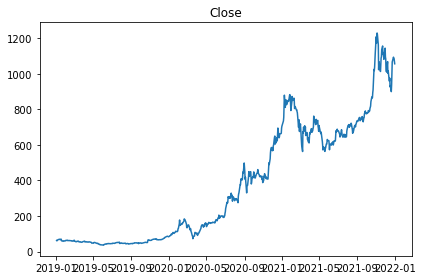

In [86]:
dates = df.index.to_numpy()
pyplot.plot(dates, df["Close"], label="Close")
pyplot.title("Close")
pyplot.tight_layout()
pyplot.show()

### Function For Converting Time Series Data For Supervised Learning

In [77]:
# convert series to supervised learning
# developed in this blog post https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, col_names, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df_temp = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df_temp.shift(i))
        names += [('%s(t-%d)' % (col_names[j], i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df_temp.shift(-i))
        if i == 0:
            names += [('%s(t)' % (col_names[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (col_names[j], i)) for j in range(n_vars)]
	# put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
	# drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### Conversion of Time Series Data

In [87]:
from sklearn.preprocessing import MinMaxScaler

values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features, makes it easier for the model to train on
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)

In [88]:
n_in = 30               # look back
n_out = 365             # look forward
n_predict = 1           # n_predict = number of data points you want to predict / n_out
percent_train = 0.70    # percent as decimal

# frame as supervised learning
reframed = series_to_supervised(scaled, df.columns, n_in, n_out)
# Drop Columns of Variables We Aren't Predicting
for i in range(1, n_out):
#    reframed.drop(reframed.loc[:, ('Open(t+%i)' %(i)):('Low(t+%i)' %(i))], axis=1, inplace=True)
    reframed.drop(reframed.loc[:, ('Tesla Trend(t+%i)' %(i)):('Day of the Week(t+%i)' %(i))], axis=1, inplace=True)
#reframed.drop(reframed.loc[:, 'Open(t)':'Low(t)'], axis=1, inplace=True)
reframed.drop(reframed.loc[:, 'Tesla Trend(t)':'Day of the Week(t)'], axis=1, inplace=True)

y_vals = reframed.iloc[:,n_out*-1:].values
x_vals = reframed.iloc[:,:n_out*-1].values
# split into train, test, and prediction sets
n_train = floor((len(x_vals)-n_predict) * percent_train)
# split into input and outputs
train_X, train_y = x_vals[:n_train, :], y_vals[:n_train, :]
test_X, test_y = x_vals[n_train:len(x_vals)-n_predict, :], y_vals[n_train:len(y_vals)-n_predict, :]
predict_X, predict_y = x_vals[len(x_vals)-n_predict:, :], y_vals[len(y_vals)-n_predict:, :]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((n_train, n_in, len(df.columns)))
test_X = test_X.reshape((test_X.shape[0], n_in, len(df.columns)))
predict_X = predict_X.reshape((n_predict, n_in, len(df.columns)))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, predict_X.shape, predict_y.shape)
reframed.head()

(253, 30, 5) (253, 365) (109, 30, 5) (109, 365) (1, 30, 5) (1, 365)


,Close(t-30),Tesla Trend(t-30),Month(t-30),Day of the Month(t-30),Day of the Week(t-30),Close(t-29),Tesla Trend(t-29),Month(t-29),Day of the Month(t-29),Day of the Week(t-29),...,Close(t+355),Close(t+356),Close(t+357),Close(t+358),Close(t+359),Close(t+360),Close(t+361),Close(t+362),Close(t+363),Close(t+364)
30,0.021966,0.0000,0.0,0.033333,0.50,0.020331,0.0864,0.0,0.066667,0.75,...,0.224070,0.228963,0.221364,0.221397,0.245207,0.232706,0.236721,0.223446,0.207355,0.227889
31,0.020331,0.0864,0.0,0.066667,0.75,0.023234,0.0864,0.0,0.100000,1.00,...,0.228963,0.221364,0.221397,0.245207,0.232706,0.236721,0.223446,0.207355,0.227889,0.217319
32,0.023234,0.0864,0.0,0.100000,1.00,0.026126,0.0000,0.0,0.200000,0.00,...,0.221364,0.221397,0.245207,0.232706,0.236721,0.223446,0.207355,0.227889,0.217319,0.221107
33,0.026126,0.0000,0.0,0.200000,0.00,0.026192,0.0000,0.0,0.233333,0.25,...,0.221397,0.245207,0.232706,0.236721,0.223446,0.207355,0.227889,0.217319,0.221107,0.219161
34,0.026192,0.0000,0.0,0.233333,0.25,0.026724,0.0525,0.0,0.266667,0.50,...,0.245207,0.232706,0.236721,0.223446,0.207355,0.227889,0.217319,0.221107,0.219161,0.209660


## Running Model

### Function For Running Model

In [89]:
# Import keras libraries
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.constraints import NonNeg
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [90]:
# Design Network
def fit_lstm(train_X, train_y, test_X, test_y, n_out, batch_size, n_epochs, n_neurons, dropout=0.0, lr=0.001, v=0):

    model = Sequential()
    model.add(LSTM(n_neurons, return_sequences=False, input_shape=(train_X.shape[1], train_X.shape[2]), dropout=dropout))
    model.add(Dense(n_out, activation="linear", kernel_constraint=NonNeg()))

    opt = Adam(learning_rate=lr)
    model.compile(loss='mae', optimizer=opt, metrics=['accuracy'])

    # fit network
    history = model.fit(train_X, train_y, epochs=n_epochs, batch_size=batch_size, validation_data=(test_X, test_y), verbose=v, shuffle=False)

    # Return model, model training history, and prediction
    return model, history

### Testing Loop

Batch Size = 60
Trial 1 Normalized RMSE: 0.2861 | Trial 2 Normalized RMSE: 0.3646 | Trial 3 Normalized RMSE: 0.2987 | Trial 4 Normalized RMSE: 0.3259 | Trial 5 Normalized RMSE: 0.3167 | 


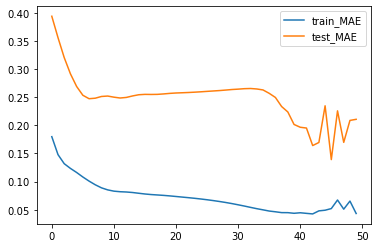

Best NRMSE: 0.2861

Batch Size = 100
Trial 1 Normalized RMSE: 0.3746 | Trial 2 Normalized RMSE: 0.3185 | Trial 3 Normalized RMSE: 0.3129 | Trial 4 Normalized RMSE: 0.4260 | Trial 5 Normalized RMSE: 0.3171 | 


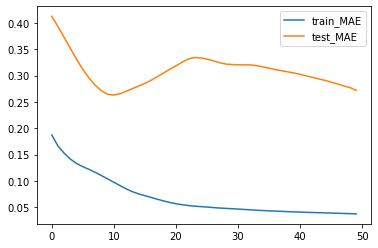

Best NRMSE: 0.3129

Batch Size = 150
Trial 1 Normalized RMSE: 0.4057 | Trial 2 Normalized RMSE: 0.4016 | Trial 3 Normalized RMSE: 0.4035 | Trial 4 Normalized RMSE: 0.4285 | Trial 5 Normalized RMSE: 0.4042 | 


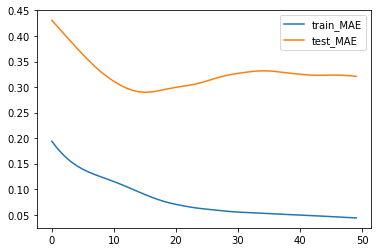

Best NRMSE: 0.4016

Batch Size = 200
Trial 1 Normalized RMSE: 0.3535 | Trial 2 Normalized RMSE: 0.3869 | Trial 3 Normalized RMSE: 0.3671 | Trial 4 Normalized RMSE: 0.3554 | Trial 5 Normalized RMSE: 0.3821 | 


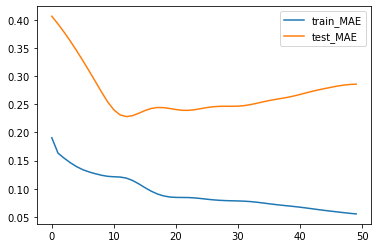

Best NRMSE: 0.3535

Batch Size = 250
Trial 1 Normalized RMSE: 0.4108 | Trial 2 Normalized RMSE: 0.3915 | Trial 3 Normalized RMSE: 0.3926 | Trial 4 Normalized RMSE: 0.4306 | Trial 5 Normalized RMSE: 0.4162 | 


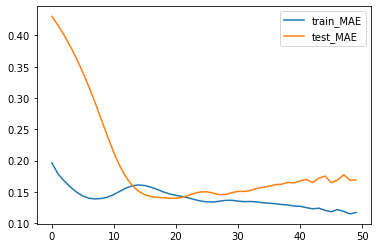

Best NRMSE: 0.3915

Batch Size = 300
Trial 1 Normalized RMSE: 0.4455 | Trial 2 Normalized RMSE: 0.4728 | Trial 3 Normalized RMSE: 0.4255 | Trial 4 Normalized RMSE: 0.4488 | Trial 5 Normalized RMSE: 0.4672 | 


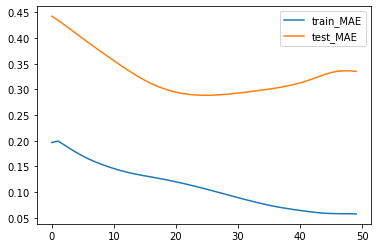

Best NRMSE: 0.4255

Batch Size = 400
Trial 1 Normalized RMSE: 0.4301 | Trial 2 Normalized RMSE: 0.4074 | Trial 3 Normalized RMSE: 0.4311 | Trial 4 Normalized RMSE: 0.4101 | Trial 5 Normalized RMSE: 0.4417 | 


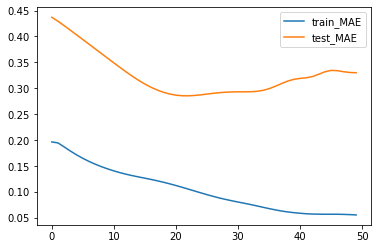

Best NRMSE: 0.4074

Batch Size = 500
Trial 1 Normalized RMSE: 0.3943 | Trial 2 Normalized RMSE: 0.4213 | Trial 3 Normalized RMSE: 0.4571 | Trial 4 Normalized RMSE: 0.4023 | Trial 5 Normalized RMSE: 0.4920 | 


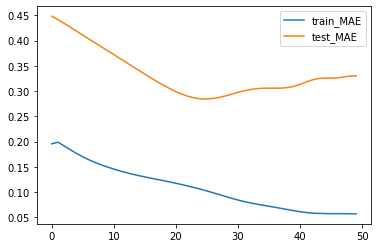

Best NRMSE: 0.3943

Batch Size = 600
Trial 1 Normalized RMSE: 0.4449 | Trial 2 Normalized RMSE: 0.4389 | Trial 3 Normalized RMSE: 0.4194 | Trial 4 Normalized RMSE: 0.4084 | Trial 5 Normalized RMSE: 0.4308 | 


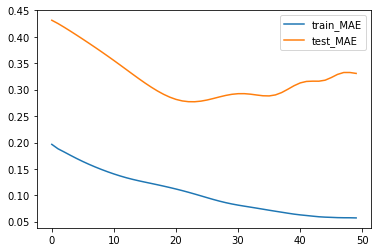

Best NRMSE: 0.4084

Batch Size = 700
Trial 1 Normalized RMSE: 0.4159 | Trial 2 Normalized RMSE: 0.4457 | Trial 3 Normalized RMSE: 0.3958 | Trial 4 Normalized RMSE: 0.4627 | Trial 5 Normalized RMSE: 0.4543 | 


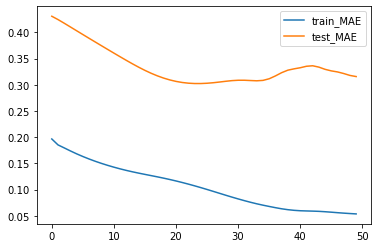

Best NRMSE: 0.3958

Batch Size = 800
Trial 1 Normalized RMSE: 0.4878 | Trial 2 Normalized RMSE: 0.4640 | Trial 3 Normalized RMSE: 0.4437 | Trial 4 Normalized RMSE: 0.4065 | Trial 5 Normalized RMSE: 0.4278 | 


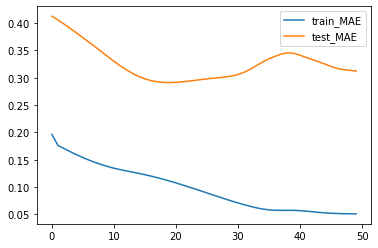

Best NRMSE: 0.4065



In [93]:
from sklearn.metrics import mean_squared_error

# Adjustable Hyperparameters
n_trials = 5
n_epochs = 50
batch_size = 700
n_neurons = 40
dropout = 0.00                                      # default is 0.0
learning_rate = 0.001                               # default is 0.001
testingArray = [60, 100, 150, 200, 250, 300, 400, 500, 600, 700, 800]
verbose = 0                                         # 0, 1, or 2

# Results Dictionary
results = {}
results["best_nrmse"] = {}
results["best_history"] = {}
results["best_invy"] = {}
results["best_invyhat"] = {}
scaler.fit(df["Close"][len(dates)-(n_out*n_predict):].values.reshape(-1,1))

for testingThing in testingArray:
    print("Batch Size = %s" %(testingThing))         # Change this to whatever parameter you're testing
    for r in range(n_trials):
        print("Trial %i " %(r+1), end="")
        model, history = fit_lstm(
            train_X, train_y, test_X, test_y, n_out, # Move testingThing to whatever parameter you're testing
            batch_size=testingThing,                
            n_epochs=n_epochs,
            n_neurons=n_neurons,
            dropout=dropout,
            lr=learning_rate,
            v=verbose
        )
        # Make Prediction
        yhat = model.predict(predict_X)
        inv_yhat = scaler.inverse_transform(yhat.reshape(-1,1)).reshape(n_out*n_predict)
        inv_y = scaler.inverse_transform(predict_y).reshape(n_out*n_predict)
        # calculate RMSE and NRMSE
        rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
        normalized_rmse = rmse/(mean(inv_y))
        print('Normalized RMSE: %.4f | ' % normalized_rmse, end="")
        # Store the model with the best NRMSE
        if testingThing not in results["best_nrmse"] or normalized_rmse < results["best_nrmse"][testingThing]:
            results["best_nrmse"][testingThing] = normalized_rmse
            results["best_history"][testingThing] = history
            results["best_invy"][testingThing] = inv_y
            results["best_invyhat"][testingThing] = inv_yhat
    print()
    pyplot.figure()
    pyplot.plot(results["best_history"][testingThing].history['loss'], label='train_MAE')
    pyplot.plot(results["best_history"][testingThing].history['val_loss'], label='test_MAE')
    pyplot.legend()
    pyplot.show()
    print("Best NRMSE: %.4f\n" %(results["best_nrmse"][testingThing]))

## Results

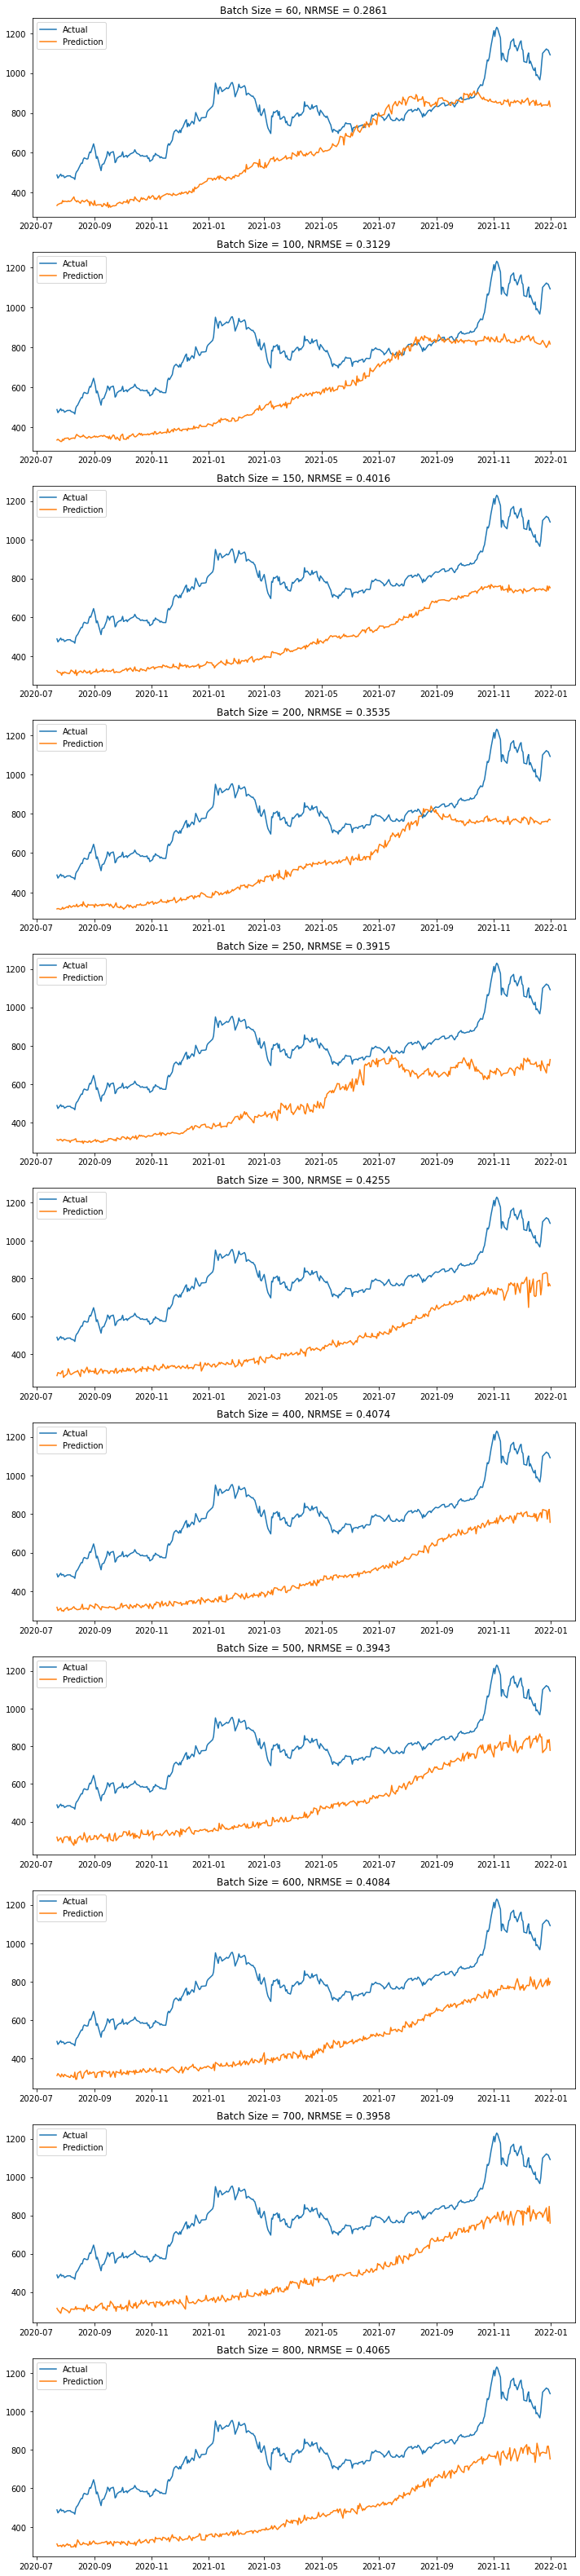

In [94]:
predictDates = dates[len(dates)-(n_out*n_predict):]
pyplot.figure(figsize=(10,4*len(testingArray)))
i = 1
for testingThing in testingArray:
    inv_y = results["best_invy"][testingThing]
    inv_yhat = results["best_invyhat"][testingThing]

    pyplot.subplot(len(testingArray), 1, i)
    pyplot.plot(predictDates, inv_y, label="Actual")
    pyplot.plot(predictDates, inv_yhat, label="Prediction")
    pyplot.legend(loc='upper left')
    pyplot.title("Batch Size = %s, NRMSE = %.4f" %(testingThing, results["best_nrmse"][testingThing])) # Change this to whatever parameter you're testing

    i+= 1

pyplot.tight_layout()
pyplot.show()
    